In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


# Reading Files

In [9]:
df = pd.read_csv('../../data/processedData/training_data.csv')
df = df.drop(['LOG_ID', 'PAT_ID', 'MRN'], axis=1)
df

,Cardiovascular,LOS,ICU_ADMIN_FLAG,HEIGHT,WEIGHT,SEX,ASA_RATING_C,Abnormal Flag,ORDER_STATUS_IMPACT,discharge_risk_level,...,ecg_std_magnitude,Calcium,Erythrocyte distribution width,Erythrocyte mean corpuscular hemoglobin,Erythrocyte mean corpuscular hemoglobin concentration,Erythrocyte mean corpuscular volume,Erythrocytes,Hematocrit,Hemoglobin,cardiac_history
0,0.0,1.0,0,187.960000,92.6991,1,2.0,0.355511,1.0,1,...,25.027281,0,0,0,0,0,0,0,0,1.0
1,0.0,10.0,1,168.251459,100.9530,1,3.0,0.355511,1.0,1,...,72.740000,0,0,0,0,0,0,0,0,1.0
2,0.0,10.0,1,168.251459,100.9530,1,3.0,0.355511,1.0,1,...,4.130000,0,0,0,0,0,0,0,0,1.0
3,0.0,3.0,1,160.020000,70.1064,0,2.0,0.355511,1.0,1,...,8.180000,0,0,0,0,0,0,0,0,1.0
4,0.0,3.0,1,168.251459,86.3922,1,2.0,0.000000,2.0,3,...,25.027281,2,1,1,1,1,2,2,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599,1.0,34.0,1,165.100000,72.1698,1,3.0,0.000000,0.0,1,...,14.240000,2,3,3,3,3,3,2,2,1.0
1600,0.0,1.0,0,154.940000,70.1592,0,3.0,2.000000,1.0,1,...,25.027281,0,0,0,0,0,0,0,0,1.0
1601,1.0,77.0,1,166.370000,52.2756,0,3.0,0.000000,0.0,1,...,25.027281,2,3,1,2,1,3,2,2,0.0
1602,0.0,7.0,1,162.560000,71.4291,0,3.0,0.000000,0.0,1,...,25.027281,2,3,3,3,3,2,2,2,0.0


# Model Fitting

### Logistic Regression Model with All Features: Performance Evaluation and ROC Curve

In [10]:
# Split the dataset into training and testing sets
X = df.drop('Cardiovascular', axis=1)  # Features (drop the target variable 'Cardiovascular')
y = df['Cardiovascular']  # Target variable

# Split data into 70% training and 30% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# Define the pipeline, including standardization and logistic regression model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardization step
    ('log_reg', LogisticRegression())  # Logistic regression model
])

# Define the hyperparameter search space
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength (C parameter)
    'log_reg__penalty': ['l1', 'l2'],  # Type of regularization (L1 or L2)
    'log_reg__solver': ['liblinear', 'saga'],  # Solver to use for optimization
    'log_reg__max_iter': [100, 200, 300]  # Maximum number of iterations
}

# Perform hyperparameter search using 20-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='accuracy', n_jobs=-1)

# Fit the model with the best hyperparameters on the training set
grid_search.fit(X_train, y_train)

# Output the best parameter combination
print("Best Parameters: ", grid_search.best_params_)

# Output the best cross-validated accuracy score on the training set
print("Best cross-validated accuracy: {:.3f}".format(grid_search.best_score_))


Best Parameters:  {'log_reg__C': 0.01, 'log_reg__max_iter': 100, 'log_reg__penalty': 'l2', 'log_reg__solver': 'saga'}
Best cross-validated accuracy: 0.856


In [12]:
# Evaluate the performance of the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate Accuracy, Precision, and Recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')

# Print performance metrics
print(f"Test set Accuracy: {accuracy:.3f}")
print(f"Test set Precision: {precision:.3f}")
print(f"Test set Recall: {recall:.3f}")

Test set Accuracy: 0.871
Test set Precision: 0.861
Test set Recall: 0.571


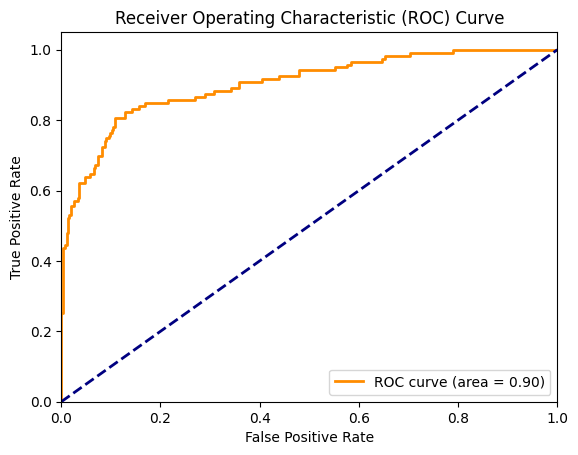

In [13]:
# Calculate the ROC curve
y_score = best_model.predict_proba(X_test)[:, 1]  # Get the predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_score)  # Compute false positive rate (fpr), true positive rate (tpr), and thresholds
roc_auc = auc(fpr, tpr)  # Calculate the area under the ROC curve (AUC)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Plot a diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()  # Display the plot

The accuracy and precision are relatively high, indicating that the model performs well in predicting positive cases. However, the recall is relatively low, which suggests that the model is not effective in identifying positive cases (i.e., patients with cardiovascular diseases), potentially missing a significant number of positive samples.

### Logistic Regression Model with Selected Features (p-value < 0.1): Performance Evaluation and ROC Curve

In [14]:
X_with_constant = sm.add_constant(X)  # Add a constant term to the model
logit_model = sm.Logit(y, X_with_constant)  # Create a logistic regression model
result = logit_model.fit()  # Fit the logistic regression model

# Get p-values
p_values = result.pvalues  # Extract the p-values from the model

# Select variables with p-values < 0.1
significant_vars = p_values[p_values < 0.1].index.tolist()  # Select variables with p-values < 0.1
significant_vars.remove('const')  # Remove the constant term

# Train the model based on the selected significant variables
X_significant = X[significant_vars]  # Create a new dataset with the significant variables
print(X_significant)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_significant, y, test_size=0.3, random_state=42)  # 30% test set


Optimization terminated successfully.
         Current function value: 0.329072
         Iterations 8
       LOS  ASA_RATING_C  ORDER_STATUS_IMPACT  arc_peak_frequency  \
0      1.0           2.0                  1.0            4.843582   
1     10.0           3.0                  1.0            2.060000   
2     10.0           3.0                  1.0            9.040000   
3      3.0           2.0                  1.0            1.600000   
4      3.0           2.0                  2.0            4.843582   
...    ...           ...                  ...                 ...   
1599  34.0           3.0                  0.0            0.560000   
1600   1.0           3.0                  1.0            4.843582   
1601  77.0           3.0                  0.0            4.843582   
1602   7.0           3.0                  0.0            4.843582   
1603   7.0           3.0                  0.0            4.843582   

      Erythrocyte distribution width  Erythrocyte mean corpuscular he

In [15]:
# Create a Pipeline that includes Logistic Regression and perform 20-fold cross-validation with hyperparameter tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardization step
    ('log_reg', LogisticRegression(solver='liblinear'))  # Logistic regression model
])

# Define the hyperparameter search space
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter C for logistic regression
}

# Perform 20-fold cross-validation for hyperparameter search
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='accuracy', n_jobs=-1)

# Conduct hyperparameter search on the training set
grid_search.fit(X_train, y_train)

# Output the best parameter combination
print("Best Parameters: ", grid_search.best_params_)


Best Parameters:  {'log_reg__C': 0.1}


Test set Accuracy: 0.880
Test set Precision: 0.821
Test set Recall: 0.655


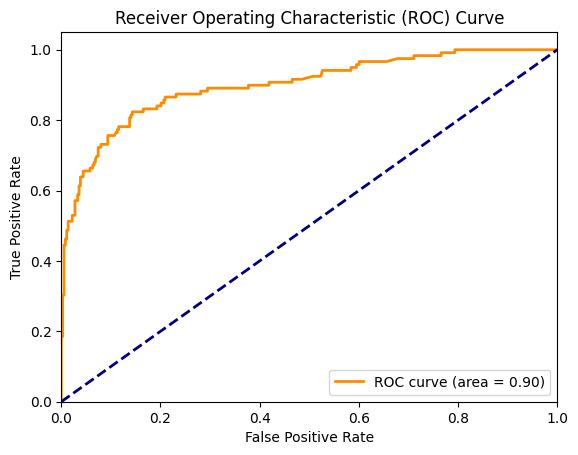

In [16]:
# Evaluate the model performance
best_model = grid_search.best_estimator_

# Calculate Accuracy, Precision, and Recall
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Test set Accuracy: {accuracy:.3f}")
print(f"Test set Precision: {precision:.3f}")
print(f"Test set Recall: {recall:.3f}")

# Calculate ROC curve
y_score = best_model.predict_proba(X_test)[:, 1]  # Get the predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


### Logistic Regression with Selected Features (p-value < 0.05): Model Performance and ROC Curve

In [17]:
# Add a constant term to the feature set
X_with_constant = sm.add_constant(X)

# Fit a logistic regression model using the selected features
logit_model = sm.Logit(y, X_with_constant)
result = logit_model.fit()

# Get p-values for each feature
p_values = result.pvalues

# Filter variables with p-values < 0.05
significant_vars = p_values[p_values < 0.05].index.tolist()
significant_vars.remove('const')  # Remove the constant term

# Train the model using only the significant variables
X_significant = X[significant_vars]
print(X_significant)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_significant, y, test_size=0.3, random_state=42)

Optimization terminated successfully.
         Current function value: 0.329072
         Iterations 8
       LOS  ASA_RATING_C  ORDER_STATUS_IMPACT  Erythrocyte distribution width  \
0      1.0           2.0                  1.0                               0   
1     10.0           3.0                  1.0                               0   
2     10.0           3.0                  1.0                               0   
3      3.0           2.0                  1.0                               0   
4      3.0           2.0                  2.0                               1   
...    ...           ...                  ...                             ...   
1599  34.0           3.0                  0.0                               3   
1600   1.0           3.0                  1.0                               0   
1601  77.0           3.0                  0.0                               3   
1602   7.0           3.0                  0.0                               3   
1603   

In [18]:
# Create a pipeline that includes logistic regression and perform 20-fold cross-validation with hyperparameter tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardization step
    ('log_reg', LogisticRegression(solver='liblinear'))  # Logistic regression model
])

# Define the hyperparameter search space
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter C
}

# Perform hyperparameter search using 20-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='accuracy', n_jobs=-1)

# Fit the grid search on the training set
grid_search.fit(X_train, y_train)

# Output the best combination of hyperparameters
print("Best Parameters: ", grid_search.best_params_)


Best Parameters:  {'log_reg__C': 0.1}


Test set Accuracy: 0.880
Test set Precision: 0.814
Test set Recall: 0.664


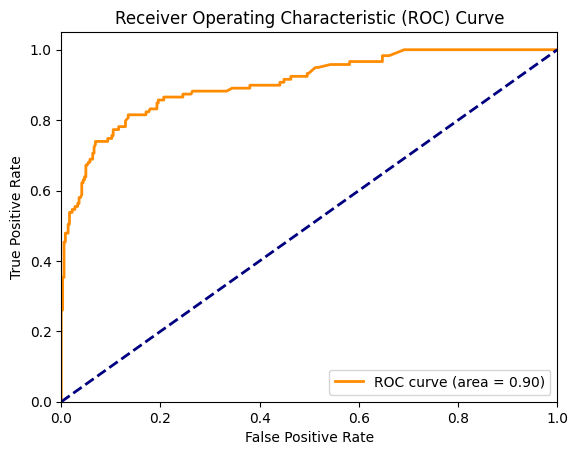

In [19]:
# Evaluate the model performance
best_model = grid_search.best_estimator_  # Retrieve the best model from the grid search

# Calculate Accuracy, Precision, Recall
y_pred = best_model.predict(X_test)  # Make predictions on the test set
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
precision = precision_score(y_test, y_pred)  # Calculate precision
recall = recall_score(y_test, y_pred)  # Calculate recall

# Print the evaluation metrics
print(f"Test set Accuracy: {accuracy:.3f}")
print(f"Test set Precision: {precision:.3f}")
print(f"Test set Recall: {recall:.3f}")

# Calculate the ROC curve
y_score = best_model.predict_proba(X_test)[:, 1]  # Get the predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_score)  # Compute false positive rate and true positive rate
roc_auc = auc(fpr, tpr)  # Calculate the area under the ROC curve (AUC)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # Plot the ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Plot the diagonal line (random guess)
plt.xlim([0.0, 1.0])  # Set x-axis limits
plt.ylim([0.0, 1.05])  # Set y-axis limits
plt.xlabel('False Positive Rate')  # Label for x-axis
plt.ylabel('True Positive Rate')  # Label for y-axis
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Title for the plot
plt.legend(loc="lower right")  # Display the legend
plt.show()  # Show the plot

The recall improved from 0.571 to 0.664 after filtering variables with p > 0.1,, meaning the model now identifies more true positive cases. While precision dropped slightly, the model's improved recall aligns with the goal of detecting more positive cases.

#### Handling Imbalanced Data with Balanced Class Weights in Logistic Regression

In [24]:
print(y.value_counts())

Cardiovascular
0.0    1206
1.0     398
Name: count, dtype: int64


From the output it can be seen that the y data is unbalanced. There are 1206 samples with a category of 0.0, while there are only 398 samples with a category of 1.0. Typically, when there is a large difference in the number of samples between categories, the model may be biased towards predicting the category with the larger number during training.

Optimization terminated successfully.
         Current function value: 0.329072
         Iterations 8
Test set Accuracy: 0.824
Test set Precision: 0.604
Test set Recall: 0.832


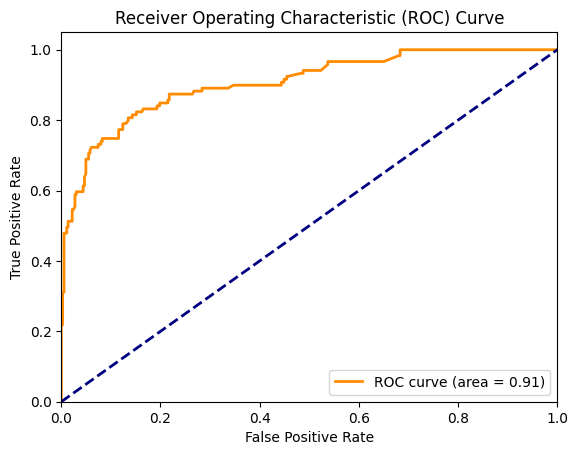

In [28]:

X = df.drop('Cardiovascular', axis=1)
y = df['Cardiovascular']
X_with_constant = sm.add_constant(X)  # Add a constant term to the model
logit_model = sm.Logit(y, X_with_constant)  # Create logistic regression model
result = logit_model.fit()  # Fit the model

# Get p-values from the model
p_values = result.pvalues

# Select variables with p-values < 0.05
significant_vars = p_values[p_values < 0.05].index.tolist()
significant_vars.remove('const')  # Remove the constant term

# Train the model based on the selected significant variables
X_significant = X[significant_vars]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_significant, y, test_size=0.3, random_state=42)

# Create a pipeline with Logistic Regression and perform 20-fold cross-validation with hyperparameter tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('log_reg', LogisticRegression(solver='liblinear', class_weight='balanced'))  # Use Logistic Regression model with balanced class weights
])

# Define the hyperparameter search space
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100]  # Regularization strength (C parameter)
}

# Use 20-fold cross-validation for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='accuracy', n_jobs=-1)

# Perform hyperparameter tuning on the training set
grid_search.fit(X_train, y_train)

# Step 5: Evaluate the model performance
best_model = grid_search.best_estimator_

# Compute Accuracy, Precision, and Recall
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Test set Accuracy: {accuracy:.3f}")
print(f"Test set Precision: {precision:.3f}")
print(f"Test set Recall: {recall:.3f}")

# Calculate the ROC curve
y_score = best_model.predict_proba(X_test)[:, 1]  # Get the predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_score)  # Compute false positive rate and true positive rate
roc_auc = auc(fpr, tpr)  # Calculate the area under the ROC curve (AUC)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # Plot the ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Plot the diagonal line (random guess)
plt.xlim([0.0, 1.0])  # Set x-axis limits
plt.ylim([0.0, 1.05])  # Set y-axis limits
plt.xlabel('False Positive Rate')  # Label for x-axis
plt.ylabel('True Positive Rate')  # Label for y-axis
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Title for the plot
plt.legend(loc="lower right")  # Display the legend
plt.show()  # Show the plot

Using `class_weight='balanced'` can improve the model's ability to identify positive class samples, though it comes at the cost of precision. This may be a better option in scenarios such as healthcare, where reducing missed diagnoses is crucial.

#### Handling Imbalanced Data Using SMOTE in Logistic Regression

Optimization terminated successfully.
         Current function value: 0.329072
         Iterations 8
Test set Accuracy: 0.873
Test set Precision: 0.750
Test set Recall: 0.731


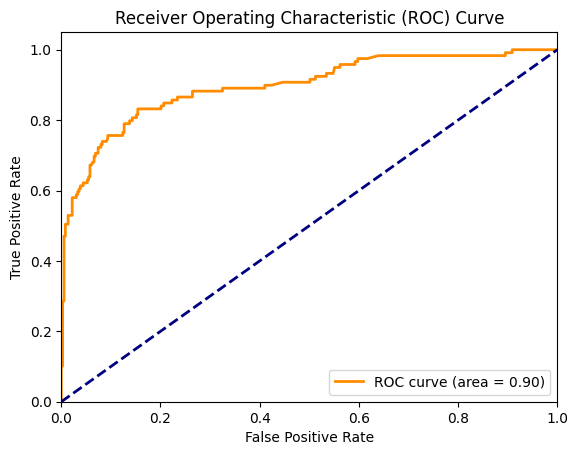

In [32]:
X = df.drop('Cardiovascular', axis=1)  # Split features from the target variable
y = df['Cardiovascular']  # Target variable

# Step 1: Select significant variables based on p-values
X_with_constant = sm.add_constant(X)  # Add constant term for intercept
logit_model = sm.Logit(y, X_with_constant)  # Logistic regression model
result = logit_model.fit()  # Fit the model

# Get p-values
p_values = result.pvalues

# Select variables where p_values < 0.1
significant_vars = p_values[p_values < 0.1].index.tolist()
significant_vars.remove('const')  # Remove the constant term

# Train the model using only significant variables
X_significant = X[significant_vars]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_significant, y, test_size=0.3, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Create a pipeline with logistic regression and perform 20-fold cross-validation and hyperparameter tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardization step
    ('log_reg', LogisticRegression(solver='liblinear'))  # Logistic regression model
])

# Define hyperparameter search space
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter C
}

# Perform hyperparameter search with 20-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='accuracy', n_jobs=-1)

# Fit the grid search on the SMOTE-processed training set
grid_search.fit(X_train_smote, y_train_smote)

# Evaluate model performance
best_model = grid_search.best_estimator_  # Get the best model

# Compute Accuracy, Precision, Recall
y_pred = best_model.predict(X_test)  # Make predictions on the test set
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
precision = precision_score(y_test, y_pred)  # Calculate precision
recall = recall_score(y_test, y_pred)  # Calculate recall

# Print evaluation results
print(f"Test set Accuracy: {accuracy:.3f}")
print(f"Test set Precision: {precision:.3f}")
print(f"Test set Recall: {recall:.3f}")

# Calculate the ROC curve
y_score = best_model.predict_proba(X_test)[:, 1]  # Get the predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_score)  # Compute false positive rate and true positive rate
roc_auc = auc(fpr, tpr)  # Calculate the area under the ROC curve (AUC)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # Plot the ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Plot the diagonal line (random guess)
plt.xlim([0.0, 1.0])  # Set x-axis limits
plt.ylim([0.0, 1.05])  # Set y-axis limits
plt.xlabel('False Positive Rate')  # Label for x-axis
plt.ylabel('True Positive Rate')  # Label for y-axis
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Title for the plot
plt.legend(loc="lower right")  # Display the legend
plt.show()  # Show the plot


Using SMOTE improved recall but slightly decreased precision and accuracy, making the model better at identifying the minority class. And comparing SMOTE and `class_weight='balanced'`, SMOTE achieved higher precision but slightly lower recall, while the balanced class weight resulted in higher recall but at the cost of reduced precision. Both methods improve the model's ability to handle imbalanced data, but SMOTE focuses more on improving precision.

Optimization terminated successfully.
         Current function value: 0.329072
         Iterations 8
Test set Accuracy: 0.824
Test set Precision: 0.604
Test set Recall: 0.832


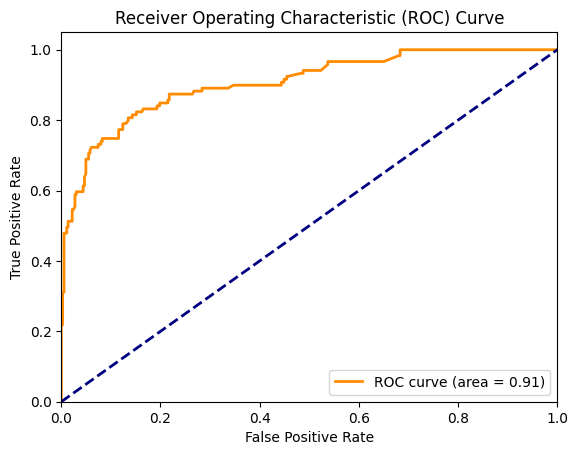

In [33]:
X = df.drop('Cardiovascular', axis=1)
y = df['Cardiovascular']
X_with_constant = sm.add_constant(X)  # Add a constant term to the model
logit_model = sm.Logit(y, X_with_constant)  # Create logistic regression model
result = logit_model.fit()  # Fit the model

# Get p-values from the model
p_values = result.pvalues

# Select variables with p-values < 0.05
significant_vars = p_values[p_values < 0.05].index.tolist()
significant_vars.remove('const')  # Remove the constant term

# Train the model based on the selected significant variables
X_significant = X[significant_vars]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_significant, y, test_size=0.3, random_state=42)

# Create a pipeline with Logistic Regression and perform 20-fold cross-validation with hyperparameter tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('log_reg', LogisticRegression(solver='liblinear', class_weight='balanced'))  # Use Logistic Regression model with balanced class weights
])

# Define the hyperparameter search space
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100]  # Regularization strength (C parameter)
}

# Use 20-fold cross-validation for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='accuracy', n_jobs=-1)

# Perform hyperparameter tuning on the training set
grid_search.fit(X_train, y_train)

# Step 5: Evaluate the model performance
best_model = grid_search.best_estimator_

# Compute Accuracy, Precision, and Recall
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Test set Accuracy: {accuracy:.3f}")
print(f"Test set Precision: {precision:.3f}")
print(f"Test set Recall: {recall:.3f}")

# Calculate the ROC curve
y_score = best_model.predict_proba(X_test)[:, 1]  # Get the predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_score)  # Compute false positive rate and true positive rate
roc_auc = auc(fpr, tpr)  # Calculate the area under the ROC curve (AUC)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # Plot the ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Plot the diagonal line (random guess)
plt.xlim([0.0, 1.0])  # Set x-axis limits
plt.ylim([0.0, 1.05])  # Set y-axis limits
plt.xlabel('False Positive Rate')  # Label for x-axis
plt.ylabel('True Positive Rate')  # Label for y-axis
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Title for the plot
plt.legend(loc="lower right")  # Display the legend
plt.show()  # Show the plot